# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging 
import csv

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier

import random
import math
from sklearn import tree, preprocessing
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.ensemble import AdaBoostClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, CSVLogger
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold


Using TensorFlow backend.


# Functions

In [2]:
def MAPE(pred,act):
    return np.mean(np.abs(pred-act)/act)*100

def Pred_correct(pred,act):
    correct = np.abs(pred-act)
    return len(correct[correct==0])/len(act)

def convert_out(data):
    output = []
    for i in range(np.shape(data)[0]):
        loc = np.where(data[i,]==max(data[i,]))[0]
        output.append(loc[0]+1)
    return(output)

def create_model_nn(neurons=1,optimizer='adam'):
# create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=14, kernel_initializer='normal', activation='relu'))
    model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def create_model_tree():
    dtree = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best', max_leaf_nodes = 90, min_samples_leaf = 1, max_depth=3)

    

# Preprocessing data

In [13]:
data = pd.read_csv('winequality-white.csv',sep=';')
X = data.values[:,0:-1]
Y_first = data.values[:,-1]
Y = []
out = np.zeros(shape=[11])
for i in range(np.shape(Y_first)[0]):
    out[int(Y_first[i])-1]=1
    Y.append(out)
    out = np.zeros(shape=[11])
Y = np.array(Y)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
df_normalized = pd.DataFrame(np_scaled)

r,c = np.shape(df_normalized)

total_samples = list(np.arange(0,r,1))
test_samples = random.sample(total_samples,int(np.round(len(total_samples)*0.2)))
train_samples = list(set(total_samples) - set(test_samples))

# Splitting data

In [21]:
trainX = X[train_samples]
trainY = Y[train_samples]
trainY_comp = Y_first[train_samples]

testX = X[test_samples]
testY = Y[test_samples]
testY_comp = Y_first[test_samples]
print(np.shape(Y))

(4898, 11)


# Determining optimal Number of Neurons 

In [33]:
neurons_1 = np.arange(1,501,250)
neurons_2 = np.arange(1,501,250)

train_e = []
test_e = []

for i in range(len(neurons_1)):
    for j in range(len(neurons_2)):
        print(i)
        print(j)
        model = Sequential()
        model.add(Dense(neurons_1[i], input_dim=11, kernel_initializer='normal', activation='relu'))
        model.add(Dense(neurons_2[j], kernel_initializer='normal', activation='relu'))
        model.add(Dense(11, kernel_initializer='normal', activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(trainX,trainY, nb_epoch=1000, batch_size=500,verbose=0)

        train_pred_NN = convert_out(model.predict(trainX))
        train_e.append(1-Pred_correct(train_pred_NN,trainY_comp))

        test_pred_NN = convert_out(model.predict(testX))
        test_e.append(1-Pred_correct(test_pred_NN,testY_comp))


                            

0
0


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


KeyboardInterrupt: 

# Plotting Results

The optimal number of neighbors is 251


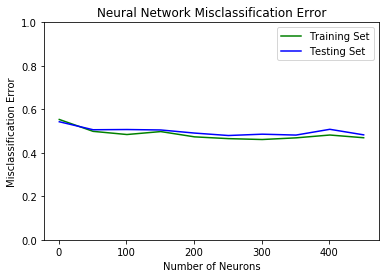

0.47959183673469385


In [27]:
# determining best number of neurons
optimal_neurons = neurons[test_e.index(min(test_e))]
print("The optimal number of neighbors is %d" % optimal_neurons)

# plot misclassification error vs k
plt.plot(neurons, train_e,'g',label='Training Set')
plt.plot(neurons,test_e,'b',label='Testing Set')
plt.xlabel('Number of Neurons')
plt.ylabel('Misclassification Error')
plt.title('Neural Network Misclassification Error')
plt.ylim([0,1])
plt.legend()
plt.show()

print(test_e[test_e.index(min(test_e))])


# Training with best structure

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


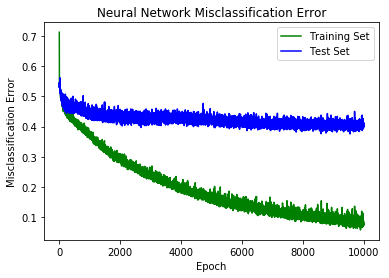

Training Set Misclassification Error is [0.07069933639612047]
Testing Set Misclassification Error is [0.40102040816326534]


In [30]:
train_all = []
test_all = []

values = random.sample(list(np.arange(0,len(trainX),1)),len(trainX))
trainX_use = trainX[values,:]
trainY_use = trainY[values,:]

model = Sequential()
model.add(Dense(optimal_neurons, input_dim=11, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(11, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(trainX,trainY, nb_epoch=10000, batch_size=500,verbose=0,validation_data=(testX,testY))
plt.plot(1-np.array(hist.history['acc']),'g')
plt.plot(1-np.array(hist.history['val_acc']),'b')
plt.title('Neural Network Misclassification Error')
plt.ylabel('Misclassification Error')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'])
plt.show()

train_pred_NN = convert_out(model.predict(trainX))
train_all.append(1-Pred_correct(train_pred_NN,trainY_comp))

test_pred_NN = convert_out(model.predict(testX))
test_all.append(1-Pred_correct(test_pred_NN,testY_comp))


print('Training Set Misclassification Error is', train_all)
print('Testing Set Misclassification Error is', test_all)                           

# Improving the results by using a validation set

In [34]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
    def on_epoch_end(self, epoch, logs):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        logs['test_acc'] = acc


train_all = []
test_all = []

values = random.sample(list(np.arange(0,len(trainX),1)),len(trainX))
trainX_use = trainX[values,:]
trainY_use = trainY[values,:]

model = Sequential()
model.add(Dense(optimal_neurons, input_dim=14, kernel_initializer='normal', activation='relu'))
model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint, TestCallback((testX,testY)),CSVLogger('1.log')]
hist = model.fit(trainX_use,trainY_use, validation_split =0.3, nb_epoch=5000, batch_size=10,verbose=0,callbacks=callbacks_list)
plt.plot(1-np.array(hist.history['acc']),'g')
plt.plot(1-np.array(hist.history['val_acc']),'b')
plt.plot(1-np.array(hist.history['test_acc']),'r')
plt.title('Neural Network Misclassification Error')
plt.ylabel('Misclassification Error')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set', 'Testing Set'])
plt.show()

train_pred_NN = convert_out(model.predict(trainX))
train_all.append(1-Pred_correct(train_pred_NN,trainY_comp))

test_pred_NN = convert_out(model.predict(testX))
test_all.append(1-Pred_correct(test_pred_NN,testY_comp))

print('Training Set Misclassification Error is', train_all)
print('Testing Set Misclassification Error is', test_all)    
                            

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


ValueError: Error when checking input: expected dense_336_input to have shape (14,) but got array with shape (11,)

# Testing the best network structure

In [9]:
model = Sequential()
model.add(Dense(optimal_neurons, input_dim=14, kernel_initializer='normal', activation='relu'))
model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("weights.best.hdf5")

set_val = round(len(values)*0.3)
val_pred = convert_out(model.predict(trainX_use[-set_val:]))
val_act = trainY_comp[values[-set_val:]]
val_acc = (1-Pred_correct(val_pred,val_act))

test_pred = convert_out(model.predict(testX))
test_acc = (1-Pred_correct(test_pred,testY_comp))
print(1-test_acc)
print(1-val_acc)



0.6029411764705882
0.7926829268292683


# Decision Tree with pre pruning

In [35]:
max_depth = np.arange(1,15,1)
min_leaf = np.arange(1,15,1)

train_e_prune = []
test_e_prune = []

parameters = []

for i in range(len(max_depth)):
    for j in range(len(min_leaf)):
        dtree_prune = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=max_depth[i], min_samples_leaf=min_leaf[j])
        dtree_prune.fit(trainX, trainY)

        predict_tree_prune = convert_out(dtree_prune.predict(trainX))
        train_accuracy = 1-Pred_correct(predict_tree_prune,trainY_comp)
        train_e_prune.append(train_accuracy)

        test_pred_tree_prune= convert_out(dtree_prune.predict(testX))
        test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)
        test_e_prune.append(test_accuracy)
        
        parameters.append([max_depth[i],min_leaf[j]])
        
bp = parameters[test_e_prune.index(min(test_e_prune))]
print('Training Set Misclassification is', train_e_prune[test_e_prune.index(min(test_e_prune))])      
print('Testing Set Misclassification is', test_e_prune[test_e_prune.index(min(test_e_prune))])

Training Set Misclassification is 0.1255742725880551
Testing Set Misclassification is 0.41938775510204085


# Decision Tree with pre pruning (and changing the train/test split)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


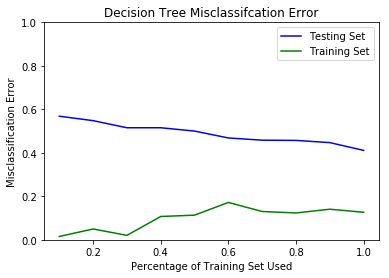

0.984693877551
0.588775510204


In [36]:
size = np.arange(0.1,1.01,0.1)

# empty list that will hold cv scores
train_errors = []
test_errors = []
n_all = []

for i in range(len(size)):
    print(size[i])
    n_all.append(size[i])
    
    total_samples = list(np.arange(0,len(trainX),1))
    train_samples = random.sample(total_samples,int(np.round(len(trainX)*size[i])))
    
    trainX_dt,trainY_dt = trainX[train_samples,:], trainY[train_samples,:]
    testX_dt, testY_dt = testX,testY

    dtree = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',\
                                       max_depth=bp[0], min_samples_leaf=bp[1])
    dtree.fit(trainX_dt,trainY_dt)
    
    predict_tree = convert_out(dtree.predict(trainX_dt))
    train_accuracy = 1-Pred_correct(predict_tree,np.array(convert_out(trainY_dt)))
    train_errors.append(train_accuracy)

    if len(testX)>0:
        test_pred_tree= convert_out(dtree.predict(testX_dt))
        test_accuracy = 1-Pred_correct(test_pred_tree,np.array(convert_out(testY_dt)))
        test_errors.append(test_accuracy)
    else:
        test_errors.append(0)
            

        

plt.plot(n_all,test_errors,'b',label='Testing Set')
plt.plot(n_all,train_errors,'g',label='Training Set')
plt.xlabel('Percentage of Training Set Used')
plt.ylabel('Misclassification Error')
plt.title('Decision Tree Misclassifcation Error')
plt.legend()
plt.ylim([0,1])
plt.show()

print(1-np.min(train_errors))
print(1-np.min(test_errors))

# dtree = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best')
# dtree.fit(trainX,trainY)

# predict_tree = convert_out(dtree.predict(trainX))
# train_accuracy = Pred_correct(predict_tree,trainY_comp)

# test_pred_tree= convert_out(dtree.predict(testX))
# test_accuracy = Pred_correct(test_pred_tree,testY_comp)

# print(train_accuracy,test_accuracy)

# Decision tree with best parameters (different training size)

In [37]:
train_e_prune = []
test_e_prune = []

dtree_prune = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                               max_depth=bp[0], min_samples_leaf=bp[1])
dtree_prune.fit(trainX, trainY)

predict_tree_prune = convert_out(dtree_prune.predict(trainX))
train_accuracy = 1-Pred_correct(predict_tree_prune,trainY_comp)

test_pred_tree_prune= convert_out(dtree_prune.predict(testX))
test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)

print('Training Set Misclassification is', train_accuracy)
print('Testing Set Misclassification is', test_accuracy)

Training Set Misclassification is 0.12608473711077084
Testing Set Misclassification is 0.41428571428571426


# Decision Tree with pre pruning and CV

In [38]:
max_depth = np.arange(1,15,1)
min_leaf = np.arange(1,15,1)

train_e_prune = []
test_e_prune = []

parameters = []

cv_scores = []
n_all = []
test_scores = []
scores_train=[]
count = 1

for i in range(len(max_depth)):
    for j in range(len(min_leaf)):
        n_all.append(count)
        count += 1
        dtree_prune = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=max_depth[i], min_samples_leaf=min_leaf[j])
        #scores = cross_val_score(dtree_prune, trainX, trainY_comp, cv=10, scoring='accuracy')
        scores_all = cross_validate(dtree_prune, trainX, trainY_comp, cv=10, scoring='accuracy')

        cv_scores.append(scores_all["test_score"].mean())
        scores_train.append(scores_all["train_score"].mean())
    

#         test_pred_tree_prune= convert_out(dtree_prune.predict(testX))
#         test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)
#         test_e_prune.append(test_accuracy)
        parameters.append([max_depth[i],min_leaf[j]])

# changing to misclassification error for training set
MSE_cv_train = [1 - x for x in scores_train]

# changing to misclassification error
MSE_cv = [1 - x for x in cv_scores]

bp = parameters[MSE_cv.index(min(MSE_cv))]
print(MSE_cv_train[MSE_cv.index(min(MSE_cv))])      
print(MSE_cv[MSE_cv.index(min(MSE_cv))])
print(bp)

dtree_prune_f = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=bp[0], min_samples_leaf=bp[1])

dtree_prune_f.fit(trainX, trainY)
test_pred_tree_prune= convert_out(dtree_prune_f.predict(testX))
test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)

predict_tree_prune = convert_out(dtree_prune_f.predict(trainX))
train_accuracy = 1-Pred_correct(predict_tree_prune,trainY_comp)

print('Training Set Misclassification is',train_accuracy)
print('Testing Set Misclassification is',test_accuracy)

# plot misclassification error vs k
# plt.plot(n_all, MSE_cv,'r',label='Validation Set')
# plt.plot(n_all,MSE_cv_train,'g',label='Training Set')
# plt.xlabel('Number of Neighbors K')
# plt.ylabel('KNN Misclassification Error')
# plt.ylim([0,1])
# plt.legend()
# plt.show()

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

0.428336914533
0.492236308574
[6, 9]
Training Set Misclassification is 0.5081674323634507
Testing Set Misclassification is 0.55


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


# KNN

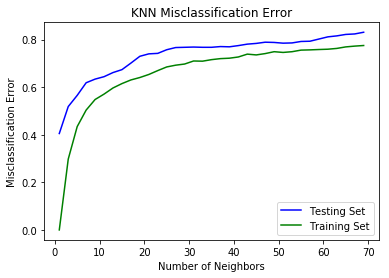

In [40]:
# creating odd list of K for KNN
myList = list(range(1,70))

# subsetting just the odd ones
#neighbors = np.arange(1,50,1)
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
train_errors = []
test_errors = []
n_all = []
for k in neighbors:
    n_all.append(k)
    model1 = KNeighborsClassifier(n_neighbors=k,metric='manhattan')

    # Train the model using the training sets
    model1.fit(trainX,trainY)

    predict_knn = convert_out(model1.predict(trainX))
    train_accuracy = 1-Pred_correct(predict_knn,trainY_comp)

    test_pred_knn= convert_out(model1.predict(testX))

    test_accuracy = 1-Pred_correct(test_pred_knn,testY_comp)
    
    train_errors.append(train_accuracy)
    test_errors.append(test_accuracy)

plt.plot(n_all,np.array(test_errors),'b',label='Testing Set')
plt.plot(n_all,np.array(train_errors),'g',label='Training Set')
plt.xlabel('Number of Neighbors')
plt.ylabel('Misclassification Error')
plt.title('KNN Misclassification Error')
plt.legend()
plt.show()

# KNN parameter search

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

The optimal number of neighbors is 45


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


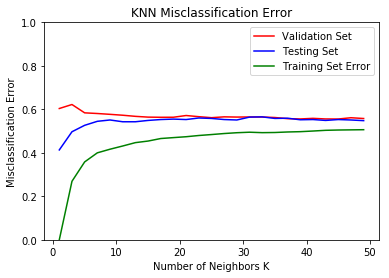

In [42]:
# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
#neighbors = np.arange(1,50,1)
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []
n_all = []
test_scores = []
scores_train=[]
# perform 10-fold cross validation
for k in neighbors:
    n_all.append(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    scores_all = cross_validate(knn, trainX, trainY_comp, cv=10, scoring='accuracy')
    cv_scores.append(scores_all["test_score"].mean())
    scores_train.append(scores_all["train_score"].mean())
    
    model1 = KNeighborsClassifier(n_neighbors=k)
    model1.fit(trainX,trainY_comp)
    test_pred_knn= model1.predict(testX)
    test_accuracy = Pred_correct(test_pred_knn,testY_comp)
    test_scores.append(test_accuracy)

# changing to misclassification error for training set
MSE_cv_train = [1 - x for x in scores_train]

# changing to misclassification error
MSE_cv = [1 - x for x in cv_scores]

# changing to misclassification error for test set
MSE_test = [1 - x for x in test_scores]

# determining best k
optimal_k = n_all[MSE_cv.index(min(MSE_cv))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(n_all, MSE_cv,'r',label='Validation Set')
plt.plot(n_all,MSE_test,'b',label='Testing Set')
plt.plot(n_all,MSE_cv_train,'g',label='Training Set Error')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.title('KNN Misclassification Error')

plt.ylim([0,1])
plt.legend()
plt.show()

# KNN with changing training set size

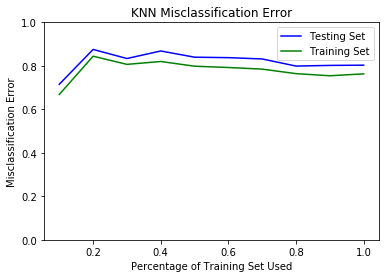

In [44]:
size = np.arange(0.1,1.01,0.1)

# empty list that will hold cv scores
train_errors = []
test_errors = []
n_all = []

for i in range(len(size)):
    n_all.append(size[i])
    
    total_samples = list(np.arange(0,len(trainX),1))
    train_samples = random.sample(total_samples,int(np.round(len(trainX)*size[i])))
    
    trainX_dt,trainY_dt = trainX[train_samples,:], trainY[train_samples,:]
    testX_dt, testY_dt = testX,testY
    
    #trainX_u, testX_u, trainY_u, testY_u = train_test_split(X, Y, test_size=size[i])

    model1 = KNeighborsClassifier(n_neighbors=optimal_k)

    # Train the model using the training sets
    model1.fit(trainX_dt,trainY_dt)

    predict_knn = convert_out(model1.predict(trainX_dt))
    train_accuracy = Pred_correct(predict_knn,np.array(convert_out(trainY_dt)))
    train_errors.append(train_accuracy)

    if len(testX)>0:
        test_pred_knn= convert_out(model1.predict(testX_dt))

        test_accuracy = Pred_correct(test_pred_knn,np.array(convert_out(testY_dt)))
        test_errors.append(test_accuracy)
    else:
        test_errors.append(0)
            

        

plt.plot(n_all,1-np.array(test_errors),'b',label='Testing Set')
plt.plot(n_all,1-np.array(train_errors),'g',label='Training Set')
plt.xlabel('Percentage of Training Set Used')
plt.ylabel('Misclassification Error')
plt.title('KNN Misclassification Error')

plt.legend()
plt.ylim([0,1])
plt.show()

# Adaboost for Decision Tree

Training Set Misclassification Error is 0.16028586013272073
Testing Set Misclassification Error is 0.37755102040816324


Text(0.5,1,'Adaboost Misclassifcation Errors')

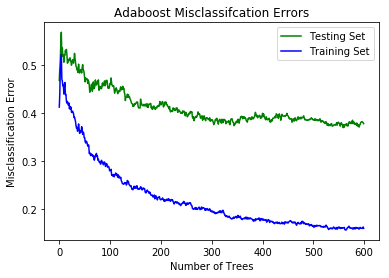

In [45]:
# bdt_real = AdaBoostClassifier(
#     DecisionTreeClassifier(criterion = "entropy", splitter = 'best'),
#     n_estimators=100)

bdt_real = AdaBoostClassifier(DecisionTreeClassifier(max_depth=bp[0], min_samples_leaf=bp[1]),
    n_estimators=600)

bdt_real.fit(trainX,trainY_comp)
predict_tree = bdt_real.predict(trainX)
train_accuracy = Pred_correct(predict_tree,trainY_comp)

test_pred_tree= bdt_real.predict(testX)
test_accuracy = Pred_correct(test_pred_tree,testY_comp)

print('Training Set Misclassification Error is',1-train_accuracy)
print('Testing Set Misclassification Error is',1-test_accuracy)

real_test_errors = []
k = 0
for real_test_predict in zip(bdt_real.staged_predict(testX)):
    real_test_errors.append(1. - Pred_correct(real_test_predict, testY_comp))

r_e = []
for real_train_errors in zip(bdt_real.staged_predict(trainX)):
    r_e.append(1. - Pred_correct(real_train_errors, trainY_comp))


plt.plot(real_test_errors,"g",label='Testing Set')
plt.plot(r_e,'b',label='Training Set')
plt.legend()
plt.ylabel('Misclassification Error')
plt.xlabel('Number of Trees')
plt.title('Adaboost Misclassifcation Errors')


Text(0.5,1,'Adaboost Misclassifcation Errors')

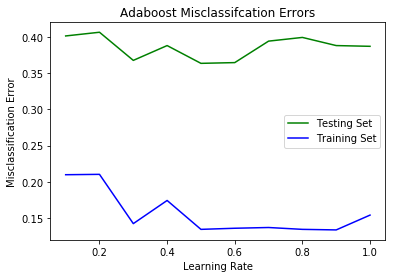

In [46]:
# bdt_real = AdaBoostClassifier(
#     DecisionTreeClassifier(criterion = "entropy", splitter = 'best'),
#     n_estimators=100)
lr = np.arange(0.1,1.01,0.1)
lr_all = []
test_accuracy = []
train_accuracy = []
for i in range(len(lr)):
    lr_all.append(lr[i])
    bdt_real = AdaBoostClassifier(DecisionTreeClassifier(max_depth=bp[0], min_samples_leaf=bp[1]),
        n_estimators=600,learning_rate=lr[i])

    bdt_real.fit(trainX,trainY_comp)
    predict_tree = bdt_real.predict(trainX)
    train_accuracy.append(1-Pred_correct(predict_tree,trainY_comp))

    test_pred_tree= bdt_real.predict(testX)
    test_accuracy.append(1-Pred_correct(test_pred_tree,testY_comp))


plt.plot(lr_all,test_accuracy,"g",label='Testing Set')
plt.plot(lr_all,train_accuracy,'b',label='Training Set')
plt.legend()
plt.ylabel('Misclassification Error')
plt.xlabel('Learning Rate')
plt.title('Adaboost Misclassifcation Errors')


In [19]:
print(bp)

[7, 3]
